In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import requests

In [2]:
# https://stackoverflow.com/questions/30557409/spotify-api-post-call-response-415
def initiate_api():    
    client_id = "9cd3dd2ea2cf492ca28ab0247a79d781"
    client_secret = "11c972ad002843e9be5ecc31f022dd6e"
    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}
    url = 'https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (client_id, client_secret)) 
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp = initiate_api()

In [41]:
songs = pd.read_pickle("pickles/songs_30k_dropped.pkl")
songs.head()

,index,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
53,1,0.000032,https://api.spotify.com/v1/audio-analysis/1MYY...,0.343,70294,0.975,1MYYt7h6amcrauCOoso3Gx,0.991,1,0.0515,-2.502,0,0.1350,119.883,4,https://api.spotify.com/v1/tracks/1MYYt7h6amcr...,audio_features,spotify:track:1MYYt7h6amcrauCOoso3Gx,0.133
54,2,0.000023,https://api.spotify.com/v1/audio-analysis/3x2m...,0.414,65306,0.959,3x2mJ2bjCIU70NrH49CtYR,0.933,7,0.3680,-4.299,0,0.0378,145.911,4,https://api.spotify.com/v1/tracks/3x2mJ2bjCIU7...,audio_features,spotify:track:3x2mJ2bjCIU70NrH49CtYR,0.589
55,3,0.053400,https://api.spotify.com/v1/audio-analysis/1Pm3...,0.522,108532,0.205,1Pm3fq1SC6lUlNVBGZi3Em,0.235,2,0.0985,-7.986,1,0.0376,103.868,4,https://api.spotify.com/v1/tracks/1Pm3fq1SC6lU...,audio_features,spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,0.353
59,7,0.201000,https://api.spotify.com/v1/audio-analysis/7dkb...,0.493,226000,0.969,7dkbEHIMLoeuG4zXGmzhEH,0.655,2,0.2470,-3.282,0,0.0463,170.581,4,https://api.spotify.com/v1/tracks/7dkbEHIMLoeu...,audio_features,spotify:track:7dkbEHIMLoeuG4zXGmzhEH,0.340
88,36,0.007740,https://api.spotify.com/v1/audio-analysis/0hBb...,0.293,658987,0.787,0hBby0yygBY1u3m6tSpZgC,0.496,5,0.3920,-8.841,1,0.0438,165.307,4,https://api.spotify.com/v1/tracks/0hBby0yygBY1...,audio_features,spotify:track:0hBby0yygBY1u3m6tSpZgC,0.138


In [42]:
songs.shape

(199252, 19)

In [43]:
song_features = songs[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness','valence']]

Text(0.5,1,'Distribution of song features in the 200k song dataset')

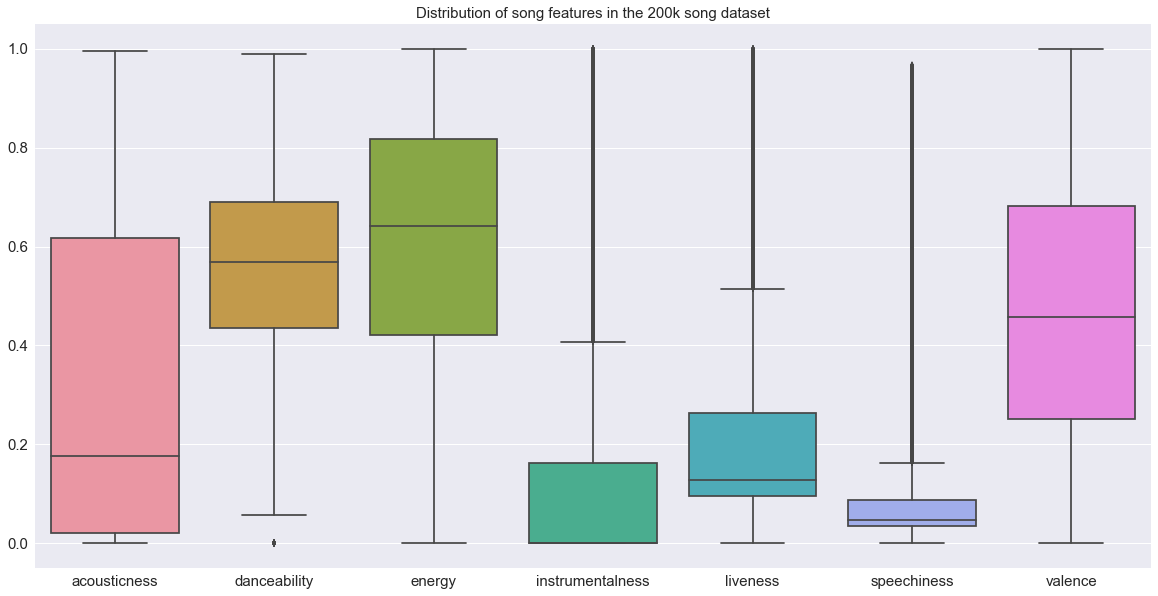

In [77]:
plt.rcParams['figure.figsize']=[20,10]
ax = sns.boxplot(data=song_features)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_title("Distribution of song features in the 200k song dataset", fontsize = 15)

In [64]:
song_duration = songs['duration_ms']/1000
song_duration = song_duration.reset_index().drop(columns = 'index')
song_tempo = songs['tempo']
song_tempo = song_tempo.reset_index().drop(columns = 'index')
song_loudness = songs['loudness']
song_loudness = song_loudness.reset_index().drop(columns = 'index')

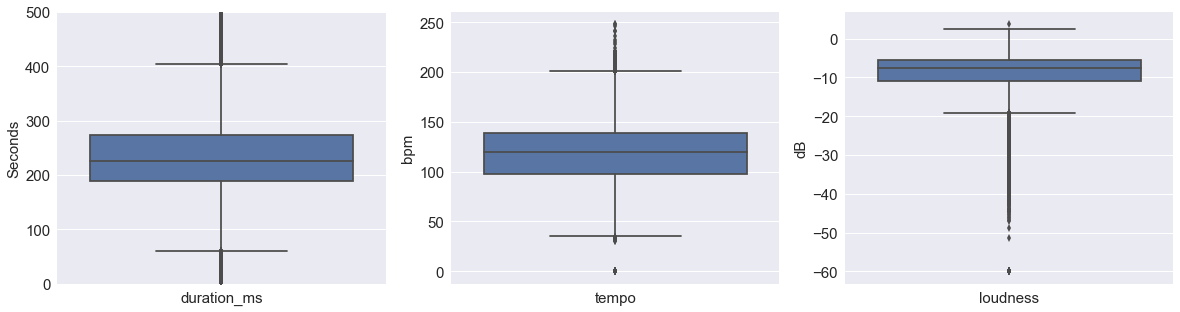

In [86]:
plt.rcParams['figure.figsize']=[20,5]
ax = plt.subplot(131)
ax = sns.boxplot(data=song_duration)
ax.set_ylim(0,500)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel("Seconds", fontsize = 15)
ax = plt.subplot(132)
ax = sns.boxplot(data=song_tempo)
ax.set_ylabel("bpm", fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax = plt.subplot(133)
ax = sns.boxplot(data=song_loudness)
ax.set_ylabel("dB", fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

In [54]:
songs.describe()

,index,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,199252.000000,199252.000000,199252.000000,1.992520e+05,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000,199252.000000
mean,37.650809,0.324306,0.556000,2.441802e+05,0.603160,0.181495,5.251491,0.208895,-8.999104,0.655286,0.088199,120.487872,3.893120,0.470437
std,27.193352,0.340081,0.180091,1.282015e+05,0.256615,0.323783,3.561136,0.188702,5.159350,0.475276,0.107022,29.685628,0.439971,0.263156
min,0.000000,0.000000,0.000000,3.056000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,0.019700,0.436000,1.883528e+05,0.422000,0.000000,2.000000,0.096300,-11.030000,0.000000,0.035100,97.410000,4.000000,0.251000
50%,32.000000,0.176000,0.569000,2.258015e+05,0.642000,0.000207,5.000000,0.128000,-7.659000,1.000000,0.047000,120.025000,4.000000,0.457000
75%,58.000000,0.617000,0.691000,2.742970e+05,0.818000,0.163000,8.000000,0.264000,-5.528000,1.000000,0.086400,138.976250,4.000000,0.682000
max,99.000000,0.996000,0.990000,5.279768e+06,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,0.967000,247.963000,5.000000,1.000000
